<a href="https://colab.research.google.com/github/rtleong/Myers-Briggs-Personality-Type-Machine-Learning-Project/blob/main/Myers_Briggs_Personality_Data_Set_ML_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#download
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import plotly.express as graph
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Import Data File
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("drive/My Drive/DataSets/mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
print ("Null Values: \n")
print (data.isnull().sum())

countCategory = data.type.value_counts()
print('\n')

print("Number of posts for each mbti Personality: \n")
print(countCategory)

graph.pie(data, names = 'type', title = 'Pie graph for types of mbti personality in the data', height = 600, width = 600)

Null Values: 

type     0
posts    0
dtype: int64


Number of posts for each mbti Personality: 

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


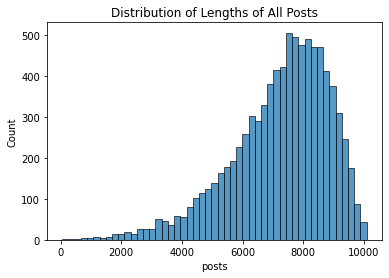

In [ ]:
dataLength = data["posts"].apply(len)
graph = sns.histplot(dataLength)
graph.set_title("Distribution of Lengths of All Posts")
print(graph)

In [ ]:
#Helper function to create a list for type indicators 
def helper(ls, ch1, Type, ind):
  i=0
  for row in Type:
    if row[ind]==ch1:
      ls[i]=1
    else :
      ls[i]=0
    i= i+1
  return ls

'''This function takes dataset as input 
   It adds 4 columns(dimnesions) for 4 type indicators(personality traits)'''
#function to add columns for 4 type indicators
def Add_Type_Indicators(data):
  IE = np.zeros(data.shape[0])
  NS = np.zeros(data.shape[0])
  TF = np.zeros(data.shape[0])
  JP = np.zeros(data.shape[0])

  Type= list(data["type"])

  IE= helper(IE, 'I', Type, 0)
  NS= helper(NS, 'N', Type, 1)
  TF= helper(TF, 'T', Type, 2)
  JP= helper(JP, 'J', Type, 3)
  

  data.insert(2, "IE", IE, True)
  data.insert(3, "NS", NS, True)
  data.insert(4, "TF", TF, True)
  data.insert(5, "JP", JP, True)

data_copy=data.copy(deep=True)
Add_Type_Indicators(data_copy)


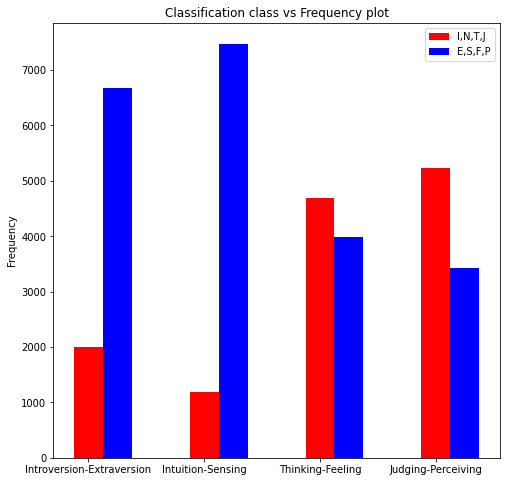

In [ ]:
# Plotting Classification class vs Frequency plot for IE, NS, TF, JP

I,N,T,J=data_copy['IE'].value_counts()[0],data_copy['NS'].value_counts()[0],data_copy['TF'].value_counts()[0],data_copy['JP'].value_counts()[0]
E,S,F,P=data_copy['IE'].value_counts()[1],data_copy['NS'].value_counts()[1],data_copy['TF'].value_counts()[1],data_copy['JP'].value_counts()[1]

plt.figure(figsize=(8,8))

coordinates=np.array(range(0,4))*2
plt.bar(coordinates-0.25,(I,N,T,J),0.5,label="I,N,T,J",color='red',tick_label=['Introversion-Extraversion','Intuition-Sensing','Thinking-Feeling','Judging-Perceiving'])
plt.bar(coordinates+0.25,(E,S,F,P),0.5,label="E,S,F,P",color='blue')

plt.legend()
plt.title('Classification class vs Frequency plot')
plt.ylabel('Frequency')
plt.show()

Correlation Matrix:
           IE        NS        TF        JP
IE  1.000000 -0.045899 -0.069573  0.161939
NS -0.045899  1.000000 -0.080954  0.014922
TF -0.069573 -0.080954  1.000000 -0.004673
JP  0.161939  0.014922 -0.004673  1.000000

HeatMap Visual:

AxesSubplot(0.125,0.125;0.62x0.755)


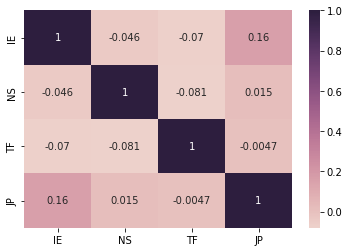

In [ ]:
#Correlation matrix and Heatmap Visuals

columns=['IE','NS','TF','JP']
matrix=data_copy[columns].corr()

print('Correlation Matrix:\n',matrix)
print('\nHeatMap Visual:\n')
print(sns.heatmap(matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True)))

# Data Pre-Processing

In [ ]:
data_copy_1 = data_copy.copy(deep=True)

In [ ]:
data_copy=data_copy_1.copy(deep=True)
#Pre-Processing
data_copy["posts"] = data_copy["posts"].str.lower()

'''This function takes a list of texual data as input.
   It performs pre-processing and natural language processing on the data.
   It returns the processed textual data list as output.'''

#remove url links
for i in range(data_copy.shape[0]):
  post_temp=data_copy._get_value(i, 'posts')
  pattern = re.compile(r'https?://[a-zA-Z0-9./-]*/[a-zA-Z0-9?=_.]*[_0-9.a-zA-Z/-]*')
  post_temp= re.sub(pattern, ' ', post_temp)
  data_copy._set_value(i, 'posts',post_temp)
  
  pattern2=re.compile(r'https?://[a-zA-Z0-9./-]*')
  post_temp=data_copy._get_value(i, 'posts')
  post_temp= re.sub(pattern, ' ', post_temp)
  data_copy._set_value(i, 'posts',post_temp)

#removing special characters and numbers from texts.
for i in range(data_copy.shape[0]):
  post_temp=data_copy._get_value(i, 'posts')
  pattern = re.compile('\W+')
  post_temp= re.sub(pattern, ' ', post_temp)
  pattern = re.compile(r'[0-9]')
  post_temp= re.sub(pattern, ' ', post_temp)
  pattern = re.compile(r'[_+]')
  post_temp= re.sub(pattern, ' ', post_temp)
  data_copy._set_value(i, 'posts',post_temp)

#removing extra spaces from texts.
for i in range(data_copy.shape[0]):
  post_temp=data_copy._get_value(i, 'posts')
  pattern = re.compile('\s+')
  post_temp= re.sub(pattern, ' ', post_temp)
  data_copy._set_value(i, 'posts', post_temp)

#remove stop words
remove_words = stopwords.words("english")
for i in range(data_copy.shape[0]):
  post_temp=data_copy._get_value(i, 'posts')
  post_temp=" ".join([w for w in post_temp.split(' ') if w not in remove_words])
  data_copy._set_value(i, 'posts', post_temp)

#remove mbti personality words from text
mbti_words =  ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
for i in range(data_copy.shape[0]):
  post_temp=data_copy._get_value(i, 'posts')
  post_temp=" ".join([w for w in post_temp.split(' ') if w not in mbti_words])
  data_copy._set_value(i, 'posts', post_temp)


In [ ]:
#data before preprocessing 
print(data.iloc[2,1], "\n")
#data after preprocessing
print(data_copy.iloc[2,1], "\n")

'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your own thoughts, and your mind just wanders in circles. Feels truly terrible. ...|||Have you noticed how peculiar vegetation can be? All you have to do is look down at the grass: dozens of different plant species there.    And now imagine that hundreds of years later (when/if soil...|||The Smiths – Never Had No One Ever|||I often find myself spotting faces on marble tiles/wood.|||This 5 year-old sentence is an incredibly accurate and beautiful description.|||I haven't visited this website in the last 3 

In [ ]:
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
#get most important words by checking word freq and using sklearn text extracter and getting lambda value
def get_top_n_imp_words(corpus,full_corpus,n=10):
    
    vec = TfidfVectorizer().fit(full_corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

imp_words_dict = {}
for personality in tqdm(data['type'].unique()):
    personality_data = data[data['type'] == personality]
    imp_words = get_top_n_imp_words(personality_data['posts'],data_copy['posts'])
    imp_words_dict[personality] = imp_words

100%|██████████| 16/16 [01:39<00:00,  6.24s/it]


In [ ]:
#Finding features using CountVectorizer by converting the posts into matrix of word count
post_list=[]
for i,j in data_copy.posts.iteritems():
  post_list.append(j)

vector=CountVectorizer(stop_words='english',max_features=1500)
features=vector.fit_transform(post_list)
# print(finalfeatures.shape)

#tf-idf to weigh the importance of words(features) across all posts and select more relevent features
transform = TfidfTransformer()
finalfeatures =  transform.fit_transform(features).toarray()

In [ ]:
print(finalfeatures.shape)

(8675, 1500)


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def show_type_properties(types):
  extracted_data=data_copy[data['type']==types]
  texts=" ".join(extracted_data['posts'].tolist())
  worldcount=WordCloud(background_color="white", max_words=200,
                   stopwords=remove_words, contour_width=3)
  worldcount.generate(texts)
  #Plot
  plt.figure(figsize=[20,6])
  plt.subplot(121)
  plt.imshow(worldcount, interpolation='bilinear')
  plt.axis("off")
  plt.subplot(122)
  tuples = imp_words_dict[types]
  words = [x[0] for x in tuples]
  imp = [x[1] for x in tuples]
  sns.barplot(y = words,x = imp)
  plt.title(f'Important Words for {types}')
  plt.xlabel('Importance - tfidf value')

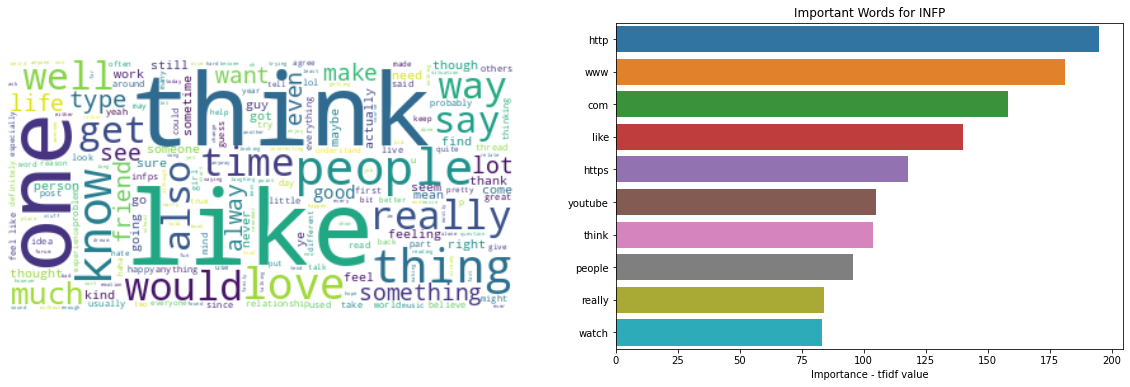

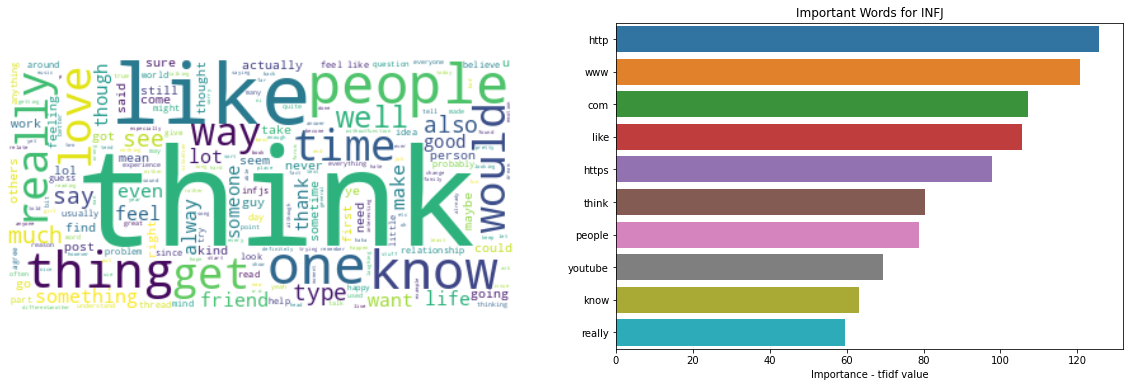

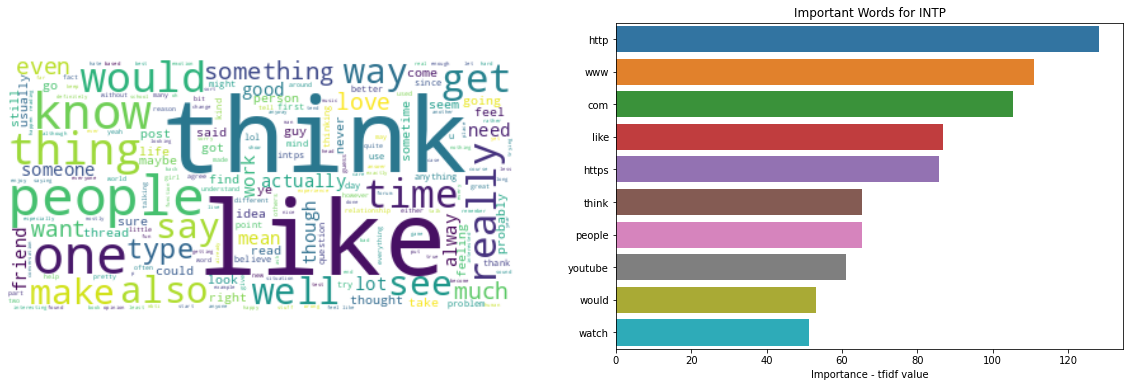

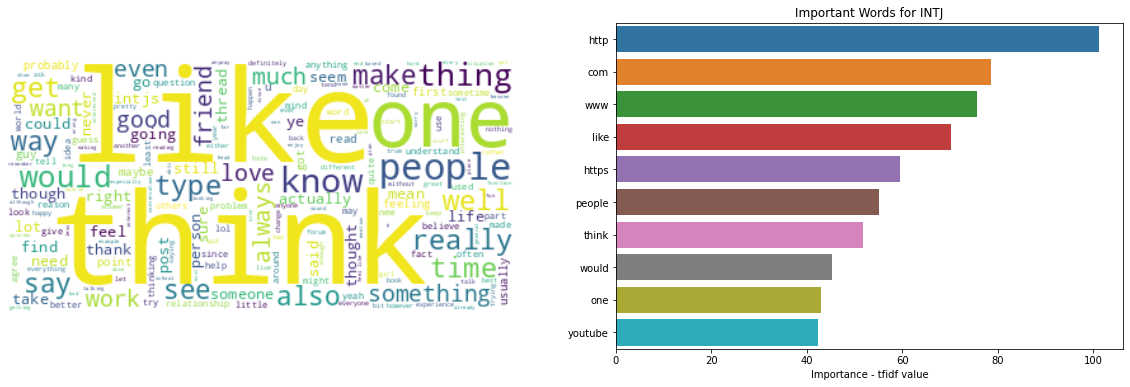

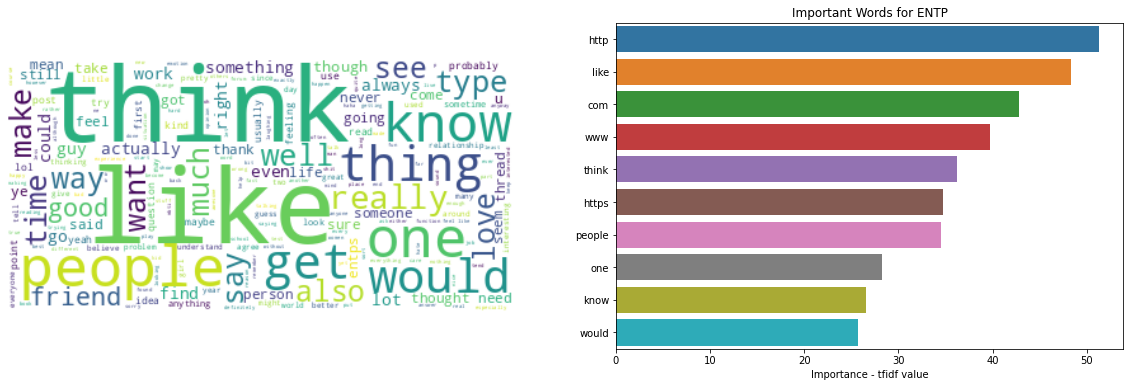

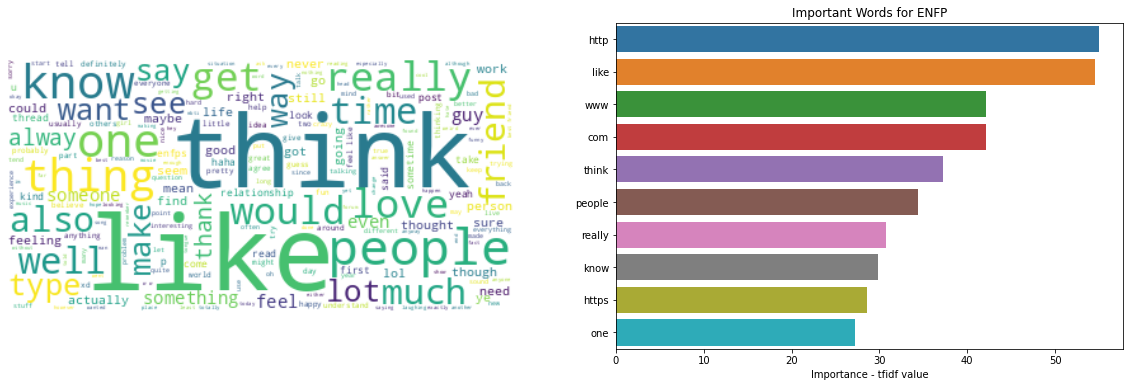

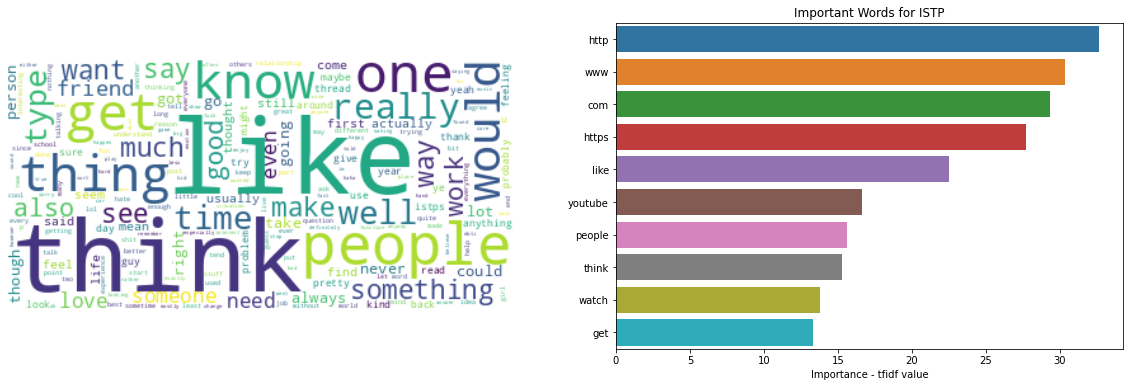

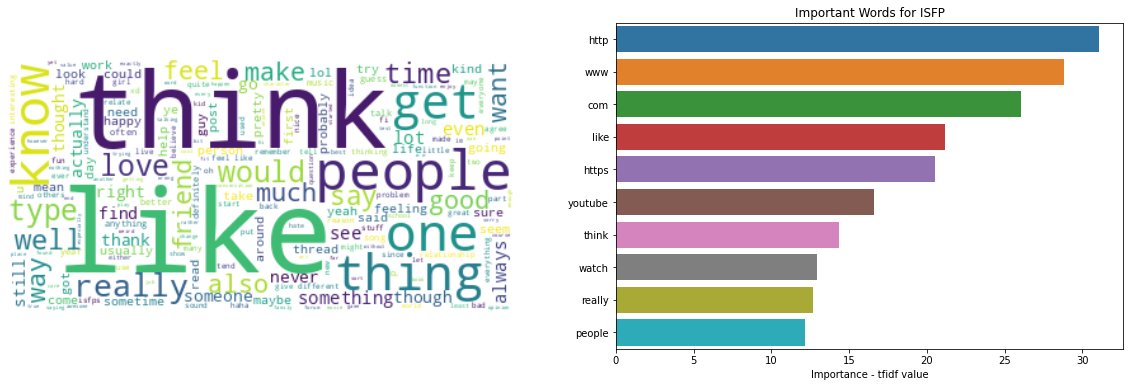

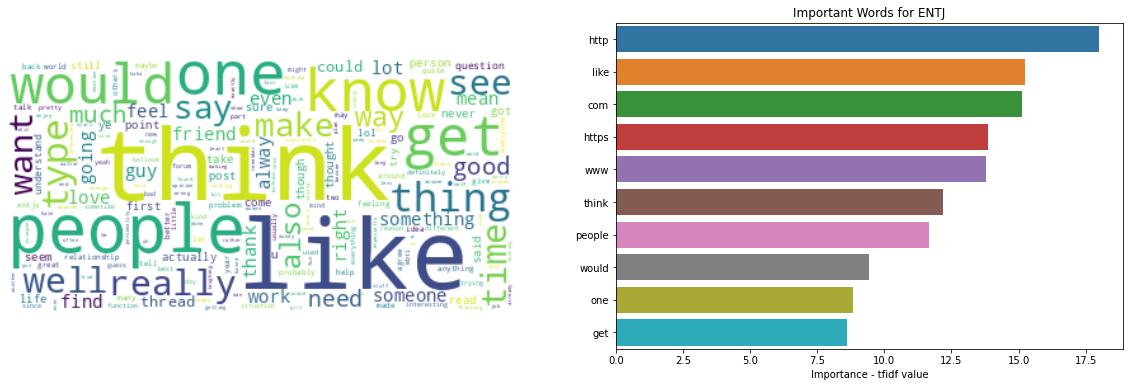

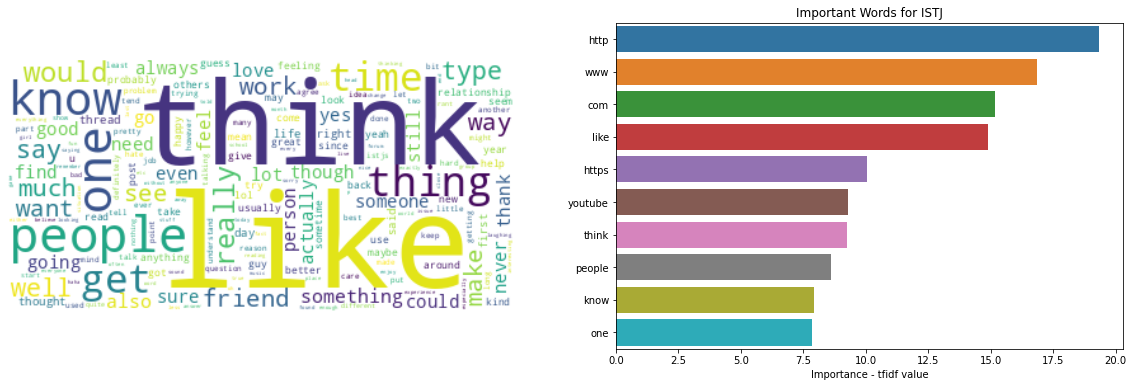

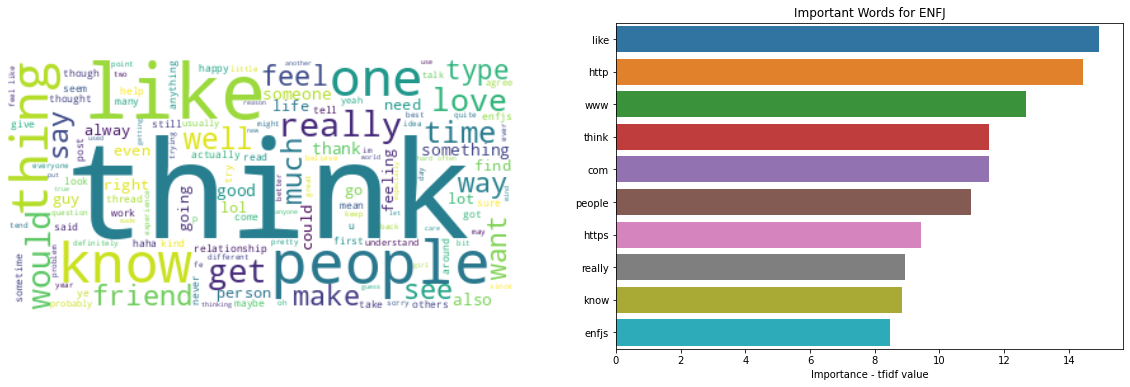

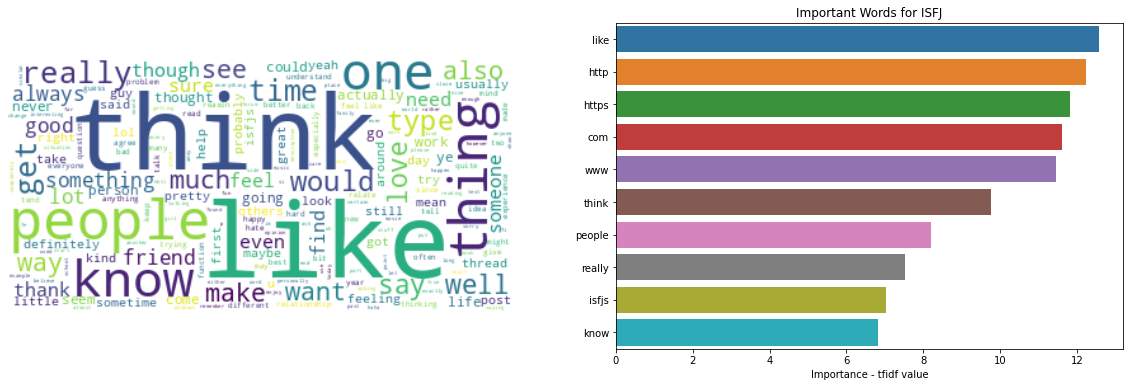

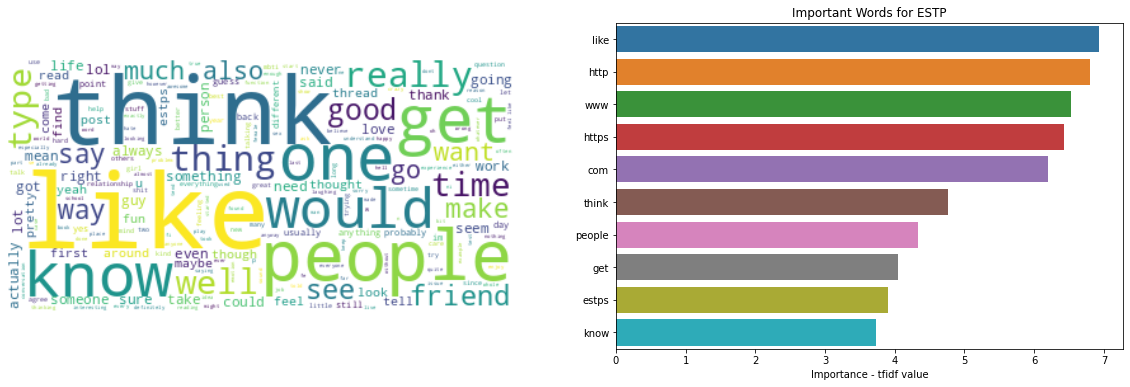

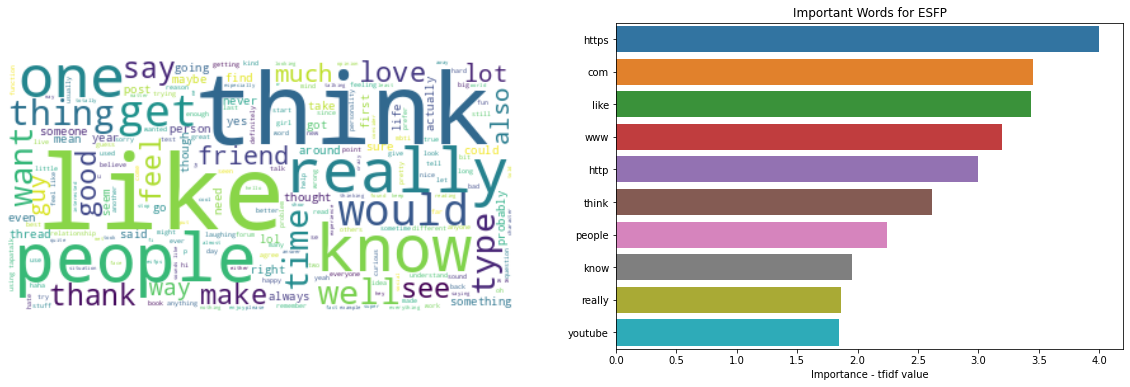

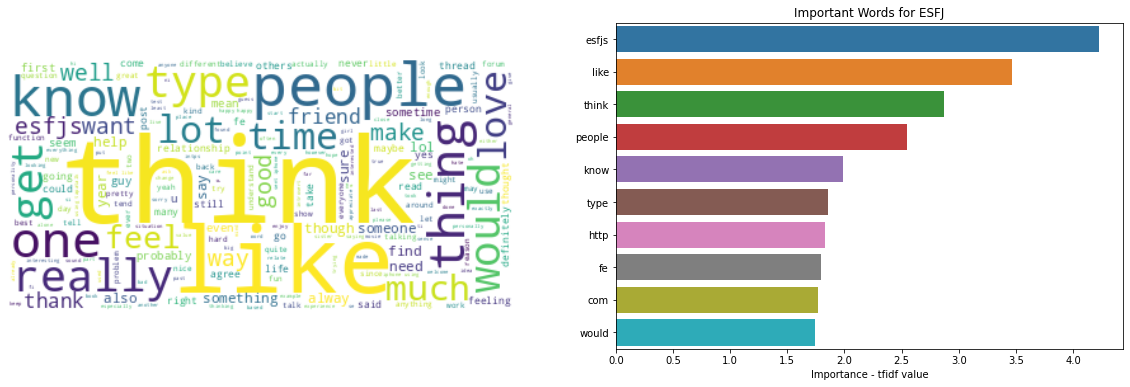

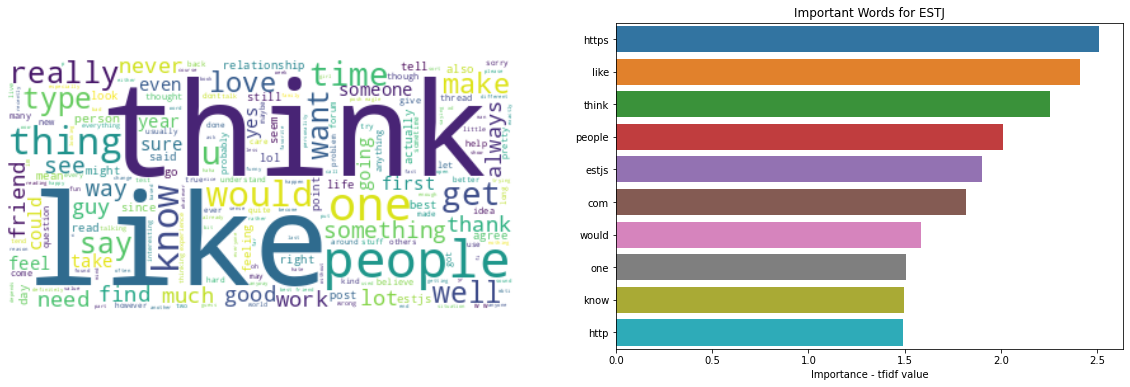

In [ ]:
for i in countCategory.index:
  show_type_properties(i)

In [ ]:
del data_copy['type']

In [ ]:
label_data = finalfeatures
feature_data = data_copy.iloc[:,1:5]

In [ ]:
#train every combination of observable type splits
X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = train_test_split(label_data, feature_data['IE'], test_size=0.2, random_state=42, stratify=feature_data)
X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = train_test_split(label_data, feature_data['NS'], test_size=0.2, random_state=42, stratify=feature_data)
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = train_test_split(label_data, feature_data['TF'], test_size=0.2, random_state=42, stratify=feature_data)
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = train_test_split(label_data, feature_data['JP'], test_size=0.2, random_state=42, stratify=feature_data)


# Model Analysis and Methodology

In [ ]:
#Function to predict labels for X_test of the given model
'''This function takes 4 GridSearchCV model as input.
  It fits all 4 models with thier resoective training data.
  It fincs the best estimator of GridSearchCV and uses 
  it to return predicted values of 4 test sets'''
def predict(model1, model2, model3, model4):
  #IE prediction
  ypredIE=model1.fit(X_train_IE,Y_train_IE).best_estimator_.predict(X_test_IE)
  #NS prediction
  ypredNS=model2.fit(X_train_NS,Y_train_NS).best_estimator_.predict(X_test_NS)
  #TF prediction
  ypredTF=model3.fit(X_train_TF,Y_train_TF).best_estimator_.predict(X_test_TF)
  #JP prediction
  ypredJP=model4.fit(X_train_JP,Y_train_JP).best_estimator_.predict(X_test_JP)

  return ypredIE, ypredNS, ypredTF, ypredJP


#Function to print Classification Report of the given model
'''This function takes 4 predicted output datasets as input.
   It computes classfication report: accuracy, recall, f1-score.
   It prints classification reports for all 4 predictions (models). '''
def print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP):
  #metrics on IE
  accuracyIE=accuracy_score(Y_test_IE,ypredIE)
  print("Accuracy for Introversion(I) / Extroversion(E): ",accuracyIE, "\n")
  print("Recall for Introversion(I) / Extroversion(E): ", metrics.recall_score(Y_test_IE, ypredIE), "\n")
  print("Precision for Introversion(I) / Extroversion(E): ", metrics.precision_score(Y_test_IE, ypredIE), "\n")
  print("F1 for Introversion(I) / Extroversion(E): ", metrics.f1_score(Y_test_IE, ypredIE), "\n")
  print("\n")

  #metrics for IS
  accuracyNS=accuracy_score(Y_test_NS,ypredNS)
  print("Accuracy for Intuition(N) / Sensing(S): ",accuracyNS, "\n")
  print("recall for Intuition(N) / Sensing(S): ", metrics.recall_score(Y_test_NS, ypredNS), "\n")
  print("precision for Intuition(N) / Sensing(S): ", metrics.precision_score(Y_test_NS, ypredNS), "\n")
  print("f1 for Intuition(N) / Sensing(S): ", metrics.f1_score(Y_test_NS, ypredNS), "\n")
  print("\n")

  #Classification Report for Thinking(T) / Feeling(F)
  accuracyTF=accuracy_score(Y_test_TF,ypredTF)
  print("Accuracy for Thinking(T) / Feeling(F): ", accuracyTF, "\n")
  print("recall for Thinking(T) / Feeling(F): ", metrics.recall_score(Y_test_TF, ypredTF), "\n")
  print("precision for Thinking(T) / Feeling(F): ", metrics.precision_score(Y_test_TF, ypredTF), "\n")
  print("f1 for Thinking(T) / Feeling(F): ", metrics.f1_score(Y_test_TF, ypredTF), "\n")
  print("\n")

  #Classification Report for Judging(J) / Perceiving(P)
  
  accuracyJP=accuracy_score(Y_test_JP,ypredJP)
  print("Accuracy for Judging(J) / Perceiving(P): ",accuracyJP, "\n")
  print("recall for Judging(J) / Perceiving(P): ", metrics.recall_score(Y_test_JP, ypredJP), "\n")
  print("precision for Judging(J) / Perceiving(P): ", metrics.precision_score(Y_test_JP, ypredJP), "\n")
  print("f1 for for Judging(J) / Perceiving(P): ", metrics.f1_score(Y_test_JP, ypredJP), "\n")
  print("\n")


#Function to print Confusion matrix for the given model
'''This function takes 4 predicted output datasets as input.
   It computes confusion matrix.
   It prints confusion matrix for all 4 predictions (models). '''
def print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP):
  #Confusion matrix for Introversion(I) / Extroversion(E):
  plt.figure()
  cm = metrics.confusion_matrix(Y_test_IE, ypredIE)
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, cmap = 'Blues_r');
  plt.ylabel('Y_test_IE');
  plt.xlabel('ypredIE');
  plt.title("Confusion matrix for Introversion(I) / Extroversion(E): ", size = 17);
  plt.show()

  #Confusion matrix for Intuition(N) / Sensing(S):
  plt.figure()
  cm = metrics.confusion_matrix(Y_test_NS, ypredNS)
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, cmap = 'Greens_r');
  plt.ylabel('Y_test_NS');
  plt.xlabel('ypredNS');
  plt.title("Confusion matrix for Intuition(N) / Sensing(S): ", size = 17);
  plt.show()

  #Confusion matrix for Judging(J) / Perceiving(P): 
  plt.figure()
  cm = metrics.confusion_matrix(Y_test_TF, ypredTF)
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, cmap = 'Reds_r');
  plt.ylabel('Y_test_TF');
  plt.xlabel('ypredTF');
  plt.title("Confusion matrix for Thinking(T) / Feeling(F): ", size = 17);
  plt.show()

  #onfusion matrix for Judging(J) / Perceiving(P):
  plt.figure()
  cm = metrics.confusion_matrix(Y_test_JP, ypredJP)
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, cmap = 'Purples_r');
  plt.ylabel('Y_test_JP');
  plt.xlabel('ypredJP');
  plt.title("Confusion matrix for Judging(J) / Perceiving(P): ", size = 17);
  plt.show()


#Function to print roc_auc_curve for the given model
'''This function takes 4 predicted probabilitie datasets as input.
   It plots ROC Curve for all 4 predictions (models). '''
def print_roc_auc_curve(probIE, probNS, probTF, probJP):
  
  fp_IE, tp_IE, val = roc_curve(Y_test_IE, probIE[:,1])
  fp_NS, tp_NS, val = roc_curve(Y_test_NS, probNS[:,1])
  fp_TF, tp_TF, val = roc_curve(Y_test_TF, probTF[:,1])
  fp_JP, tp_JP, val = roc_curve(Y_test_JP, probJP[:,1])

  plt.figure()
  plt.plot(fp_IE, tp_IE, linestyle='--', color='red', label='Introversion(I) / Extroversion(E)')
  plt.plot(fp_NS, tp_NS, linestyle='--', color='blue', label='Intuition(N) / Sensing(S)')
  plt.plot(fp_TF, tp_TF, linestyle='--', color='pink', label='Thinking(T) / Feeling(F)')
  plt.plot(fp_JP, tp_JP, linestyle='--', color='green', label='Judging(J) / Perceiving(P)')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='best')
  plt.show()

# Logistic Regression

In [ ]:
#Logistic Regression model
log =LogisticRegression(max_iter=500)
#Apply stratified cross validation
grid1= GridSearchCV(log,{},cv=5)
grid2= GridSearchCV(log,{},cv=5)
grid3= GridSearchCV(log,{},cv=5)
grid4= GridSearchCV(log,{},cv=5)
#prediction
ypredIE, ypredNS, ypredTF, ypredJP= predict(grid1, grid2, grid3, grid4)
#Print classificatio report for all four dimensions
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Accuracy for Introversion(I) / Extroversion(E):  0.8069164265129684 

Recall for Introversion(I) / Extroversion(E):  0.9767616191904048 

Precision for Introversion(I) / Extroversion(E):  0.8108276291225887 

F1 for Introversion(I) / Extroversion(E):  0.8860931655899354 



Accuracy for Intuition(N) / Sensing(S):  0.8668587896253602 

recall for Intuition(N) / Sensing(S):  0.9966555183946488 

precision for Intuition(N) / Sensing(S):  0.8682983682983683 

f1 for Intuition(N) / Sensing(S):  0.9280597944565556 



Accuracy for Thinking(T) / Feeling(F):  0.814985590778098 

recall for Thinking(T) / Feeling(F):  0.7688442211055276 

precision for Thinking(T) / Feeling(F):  0.8170894526034713 

f1 for Thinking(T) / Feeling(F):  0.7922330097087378 



Accuracy for Judging(J) / Perceiving(P):  0.7319884726224783 

recall for Judging(J) / Perceiving(P):  0.5283842794759825 

precision for Judging(J) / Perceiving(P):  0.7202380952380952 

f1 for for Judging(J) / Perceiving(P):  0.60957178841309

<Figure size 432x288 with 0 Axes>

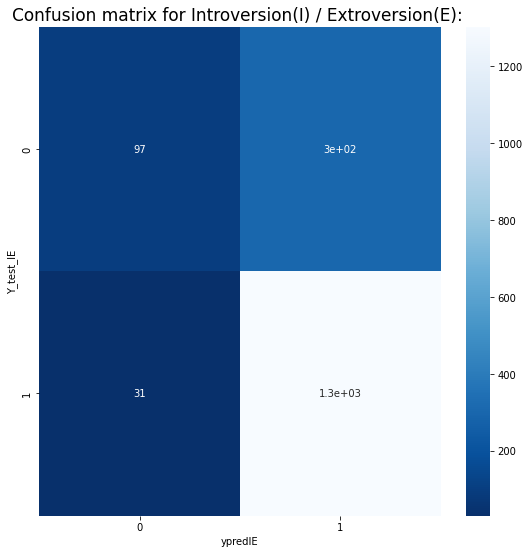

<Figure size 432x288 with 0 Axes>

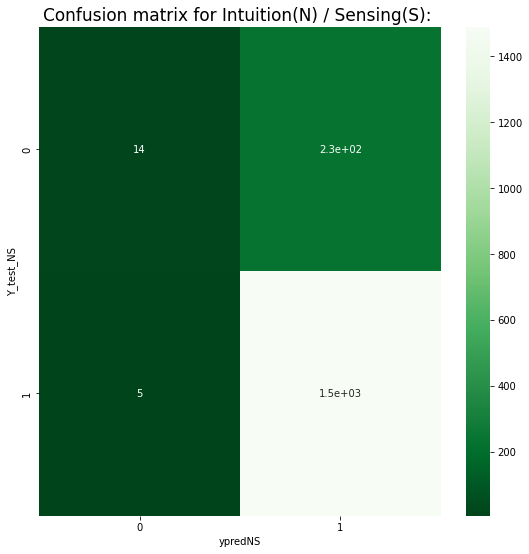

<Figure size 432x288 with 0 Axes>

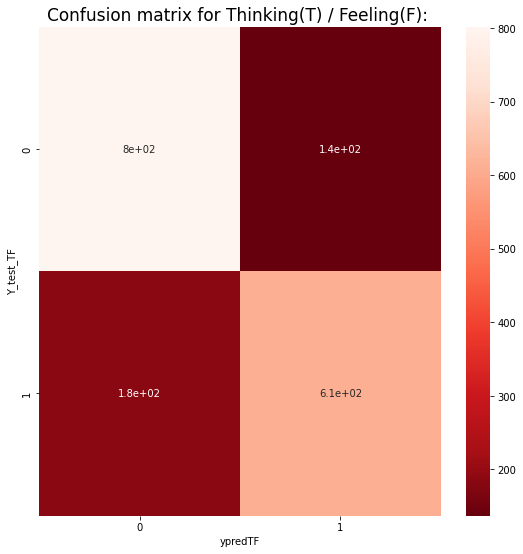

<Figure size 432x288 with 0 Axes>

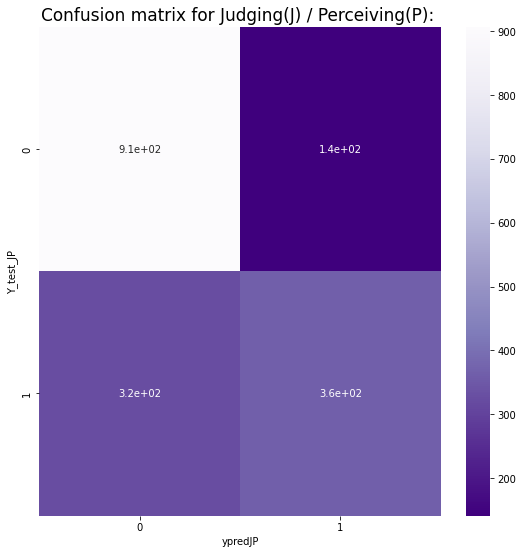

In [ ]:
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

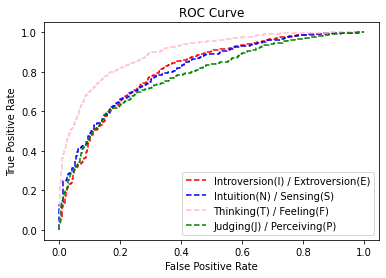

In [ ]:
#Plot ROC curve
print_roc_auc_curve(grid1.best_estimator_.predict_proba(X_test_IE), grid2.best_estimator_.predict_proba(X_test_NS),
                    grid3.best_estimator_.predict_proba(X_test_TF),grid4.best_estimator_.predict_proba(X_test_JP))

#Random Forest Classifier 

In [ ]:
'''Predictions using Random Forest Classifier'''
#IE prediction
Random_F1 = RandomForestClassifier(max_depth=9, min_samples_split=10, random_state=42)
grid1=GridSearchCV(Random_F1,{},cv=5)
ypredIE= grid1.fit(X_train_IE,Y_train_IE).best_estimator_.predict(X_test_IE)

#NS prediction
Random_F2 = RandomForestClassifier(max_depth=9, min_samples_split=10, random_state=42)
grid2=GridSearchCV(Random_F2,{},cv=5)
ypredNS= grid2.fit(X_train_NS,Y_train_NS).best_estimator_.predict(X_test_NS)

#TF prediction
Random_F3 = RandomForestClassifier(max_depth=5, min_samples_split=10, random_state=42)
grid3=GridSearchCV(Random_F3,{},cv=5)
ypredTF= grid3.fit(X_train_TF,Y_train_TF).best_estimator_.predict(X_test_TF)

#JP prediction
Random_F4 = RandomForestClassifier(max_depth=6, min_samples_split=10, random_state=42)
grid4=GridSearchCV(Random_F4,{},cv=5)
ypredJP= grid4.fit(X_train_JP,Y_train_JP).best_estimator_.predict(X_test_JP)

#Print classificatio report for all four axis
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Accuracy for Introversion(I) / Extroversion(E):  0.7688760806916427 

Recall for Introversion(I) / Extroversion(E):  1.0 

Precision for Introversion(I) / Extroversion(E):  0.7688760806916427 

F1 for Introversion(I) / Extroversion(E):  0.8693385467579016 



Accuracy for Intuition(N) / Sensing(S):  0.861671469740634 

recall for Intuition(N) / Sensing(S):  1.0 

precision for Intuition(N) / Sensing(S):  0.861671469740634 

f1 for Intuition(N) / Sensing(S):  0.9256965944272446 



Accuracy for Thinking(T) / Feeling(F):  0.7152737752161383 

recall for Thinking(T) / Feeling(F):  0.48115577889447236 

precision for Thinking(T) / Feeling(F):  0.8254310344827587 

f1 for Thinking(T) / Feeling(F):  0.6079365079365079 



Accuracy for Judging(J) / Perceiving(P):  0.6057636887608069 

recall for Judging(J) / Perceiving(P):  0.004366812227074236 

precision for Judging(J) / Perceiving(P):  1.0 

f1 for for Judging(J) / Perceiving(P):  0.008695652173913044 





In [ ]:
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True) 
params_grid = {
    'max_depth' : [4, 6, 8, 10, 20],
    'bootstrap' : [True, False],
    'criterion' :['gini', 'entropy'],
    'min_samples_split': [5, 10, 15, 20]
}


rfc_model_kfold_IE = RandomForestClassifier()
rfc_results_kfold_IE = model_selection.cross_val_score(rfc_model_kfold_IE, X_train_IE, Y_train_IE, cv=kfold)
print("Random Forest Classifier Accuracy: %.2f%%" % (rfc_results_kfold_IE.mean()*100.0)) 



grid_search_rf = GridSearchCV(rfc_model_kfold_IE, params_grid, cv= kfold, scoring ='accuracy', verbose = True)
grid_search_rf.fit(X_train_IE, Y_train_IE)

print("Best hyperparameters: ", grid_search_rf.best_params_)

Random Forest Classifier Accuracy: 77.29%
Fitting 10 folds for each of 80 candidates, totalling 800 fits


KeyboardInterrupt: ignored

## KNN classifier

In [ ]:
#K-Nearest Neighbor Model

'''Below we find the best value of K for our model.
   Analysis of accuracy vs K graph gives us the best value of K
   Analysis of accuracy vs K graph are plotted.'''
def plot_graph(val,xlab,ylab,title):
  plt.figure()
  plt.plot(val)
  plt.ylabel(ylab)
  plt.xlabel(xlab);
  plt.title(title)
  plt.show()

#IE prediction
k1_score=[]
for i in range(1,25):
  k1=KNeighborsClassifier(n_neighbors=i)
  k1.fit(X_train_IE,Y_train_IE)
  k1_score.append(k1.score(X_test_IE,Y_test_IE))

df1=pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'K','Score','K vs Score plot for IE')
print(f'Maximum Accuracy of {df1.max()[0]} at k={df1.idxmax()[0]+1}')

#NS prediction
k2_score=[]
for i in range(1,25):
  k2=KNeighborsClassifier(n_neighbors=i)
  k2.fit(X_train_NS,Y_train_NS)
  k2_score.append(k2.score(X_test_NS,Y_test_NS))

df2=pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'K','Score','K vs Score plot for NS')
print(f'Maximum Accuracy of {df2.max()[0]} at k={df2.idxmax()[0]+1}')

#TF prediction
k3_score=[]
for i in range(1,25):
  k3=KNeighborsClassifier(n_neighbors=i)
  k3.fit(X_train_TF,Y_train_TF)
  k3_score.append(k3.score(X_test_TF,Y_test_TF))

df3=pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'K','Score','K vs Score plot for TF')
print(f'Maximum Accuracy of {df3.max()[0]} at k={df3.idxmax()[0]+1}')

#JP prediction
k4_score=[]
for i in range(1,25):
  k4=KNeighborsClassifier(n_neighbors=i)
  k4.fit(X_train_JP,Y_train_JP)
  k4_score.append(k4.score(X_test_JP,Y_test_JP))

df4=pd.DataFrame(k3_score,columns=['JP'])
plot_graph(k4_score,'K','Score','K vs Score plot for JP')
print(f'Maximum Accuracy of {df4.max()[0]} at k={df4.idxmax()[0]+1}')


In [ ]:
kbest=KNeighborsClassifier(n_neighbors=df1.idxmax()[0]+1)
ypredIE=kbest.fit(X_train_IE,Y_train_IE).predict(X_test_IE)
probIE= kbest.predict_proba(X_test_IE)

kbest=KNeighborsClassifier(n_neighbors=df2.idxmax()[0]+1)
ypredNS=kbest.fit(X_train_NS,Y_train_NS).predict(X_test_NS)
probNS= kbest.predict_proba(X_test_NS)

kbest=KNeighborsClassifier(n_neighbors=df3.idxmax()[0]+1)
ypredTF=kbest.fit(X_train_TF,Y_train_TF).predict(X_test_TF)
probTF= kbest.predict_proba(X_test_TF)

kbest=KNeighborsClassifier(n_neighbors=df4.idxmax()[0]+1)
ypredJP=kbest.fit(X_train_JP,Y_train_JP).predict(X_test_JP)
probJP= kbest.predict_proba(X_test_JP)

In [ ]:
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

In [ ]:
print_roc_auc_curve(probIE, probNS, probTF, probJP)

## Naive Bayes

In [ ]:
naivegb=GaussianNB()
#Apply stratified cross validation
grid1=GridSearchCV(naivegb,{},cv=5)
grid2=GridSearchCV(naivegb,{},cv=5)
grid3=GridSearchCV(naivegb,{},cv=5)
grid4=GridSearchCV(naivegb,{},cv=5)
#prediction
ypredIE, ypredNS, ypredTF, ypredJP= predict(grid1, grid2, grid3, grid4)
#Print classificatio report for all four dimensions
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Accuracy for Introversion(I) / Extroversion(E):  0.6881844380403458 

Recall for Introversion(I) / Extroversion(E):  0.7076461769115442 

Precision for Introversion(I) / Extroversion(E):  0.8621004566210045 

F1 for Introversion(I) / Extroversion(E):  0.777274598600247 



Accuracy for Intuition(N) / Sensing(S):  0.7371757925072047 

recall for Intuition(N) / Sensing(S):  0.7618729096989967 

precision for Intuition(N) / Sensing(S):  0.9192897497982244 

f1 for Intuition(N) / Sensing(S):  0.8332114118507682 



Accuracy for Thinking(T) / Feeling(F):  0.7636887608069164 

recall for Thinking(T) / Feeling(F):  0.7361809045226131 

precision for Thinking(T) / Feeling(F):  0.7455470737913485 

f1 for Thinking(T) / Feeling(F):  0.740834386852086 



Accuracy for Judging(J) / Perceiving(P):  0.6414985590778098 

recall for Judging(J) / Perceiving(P):  0.6302765647743813 

precision for Judging(J) / Perceiving(P):  0.5405742821473158 

f1 for for Judging(J) / Perceiving(P):  0.581989247311827

<Figure size 432x288 with 0 Axes>

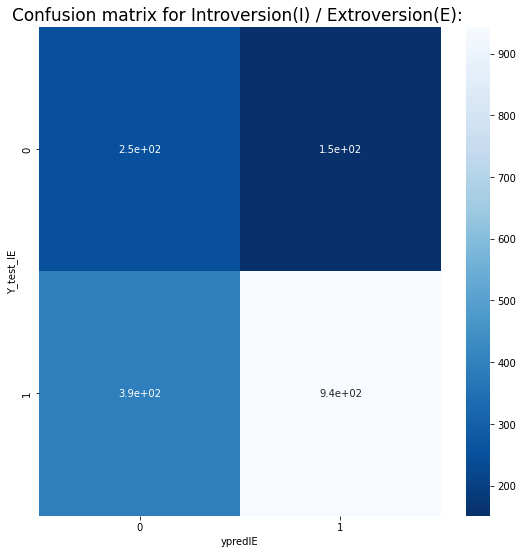

<Figure size 432x288 with 0 Axes>

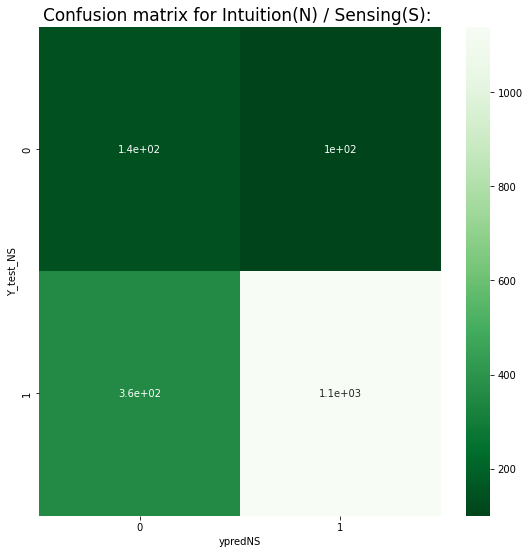

<Figure size 432x288 with 0 Axes>

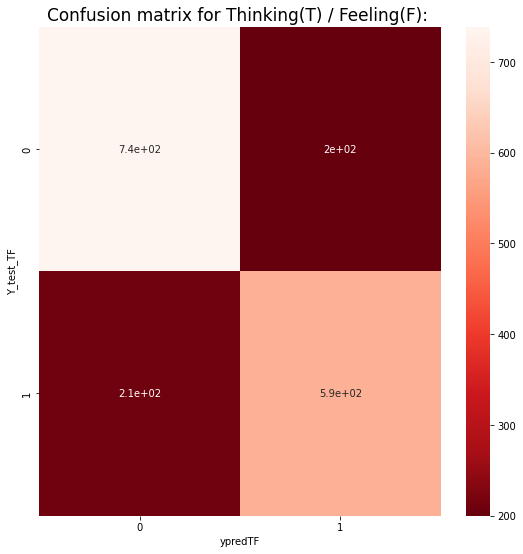

<Figure size 432x288 with 0 Axes>

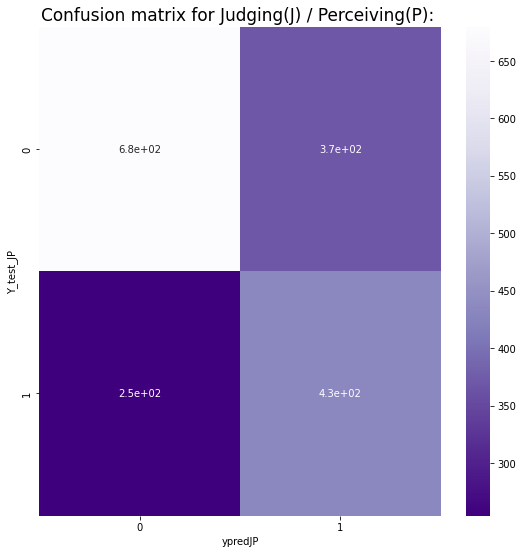

In [ ]:
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

In [ ]:
#IE prediction
svm1=SVC(random_state=42, probability=True)
svm1.fit(X_train_IE,Y_train_IE)
ypredIE=svm1.predict(X_test_IE)

#NS prediction
svm2=SVC(random_state=42, probability=True)
svm2.fit(X_train_NS,Y_train_NS)
ypredNS=svm2.predict(X_test_NS)

#TF prediction
svm3=SVC(random_state=42, probability=True)
svm3.fit(X_train_TF,Y_train_TF)
ypredTF=svm3.predict(X_test_TF)

#JP prediction
svm4=SVC(random_state=42, probability=True)
svm4.fit(X_train_JP,Y_train_JP)
ypredJP=svm4.predict(X_test_JP)

#Print classificatio report for all four axis
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

#plot ROC curve
print_roc_auc_curve(svm1.predict_proba(X_test_IE), svm2.predict_proba(X_test_NS),
                    svm3.predict_proba(X_test_TF), svm4.predict_proba(X_test_JP))